

# Leaf Segmentation with <img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="200">

Trains a detectron2 model on Superfund leaf dataset.



## Install requirements

In [1]:
# requirements
!pip install pyyaml==5.1
!pip install opencv-python
!pip install matplotlib

# cocosplit requirements
!pip install sklearn funcy argparse scikit-multilearn

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


## Split dataset into test/validation sets

In [2]:
today = "11-30"
output_folder = "kfold_output_" + today
k = 5

run = f"python ./cocosplit_kfold.py\
         --having-annotations\
         -s 0.8\
         -k {k}\
         data/leaves-coco-verified.json\
         {output_folder}" 

!{run}

<generator object _BaseKFold.split at 0x7fcb524b86d0>
False
False
False
False
False
False
False
False
False
False


In [3]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from matplotlib import pyplot as plt

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

torch:  1.12 ; cuda:  cu116


# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the balloon segmentation dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)
which only has one class: balloon.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

Register the leaf dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [4]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
from detectron2.data.datasets import register_coco_instances

for fold in range(0, k):

    register_coco_instances(f"train_{fold}", {}, f"/home/jovyan/work/{output_folder}/train_{fold}.json", "/home/jovyan/work/data/")
    register_coco_instances(f"val_{fold}", {}, f"/home/jovyan/work/{output_folder}/test_{fold}.json", "/home/jovyan/work/data/")



To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



WARNING [11/30 23:18:22 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/30 23:18:22 d2.data.datasets.coco]: Loaded 155 images in COCO format from /home/jovyan/work/kfold_output_11-30/train_1.json
Metadata(name='train_1', json_file='/home/jovyan/work/kfold_output_11-30/train_1.json', image_root='/home/jovyan/work/data/', evaluator_type='coco', thing_classes=['leaf', 'qr', 'red-square'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2})


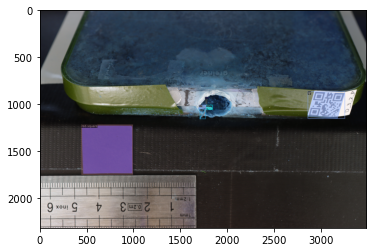

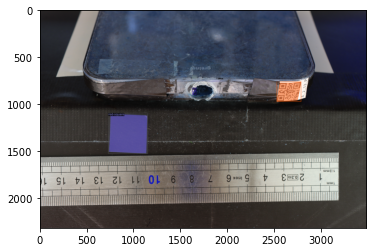

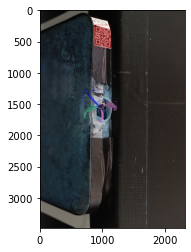

In [6]:
leaf_metadata = MetadataCatalog.get("train_1")
dataset_dicts = DatasetCatalog.get("train_1")

print(leaf_metadata)

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=leaf_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()


## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~2 minutes to train 300 iterations on a P100 GPU.


In [7]:
import os

import detectron2.data.transforms as T
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import DatasetMapper, MetadataCatalog, build_detection_train_loader
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, launch
from detectron2.evaluation import CityscapesSemSegEvaluator, DatasetEvaluators, SemSegEvaluator
from detectron2.projects.deeplab import add_deeplab_config, build_lr_scheduler


def build_sem_seg_train_aug(cfg):
    augs = [
        T.ResizeShortestEdge(
            cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MAX_SIZE_TRAIN, cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING
        )
    ]
    if cfg.INPUT.CROP.ENABLED:
        print('CROP ENABLED!!!')
        augs.append(
            T.RandomCrop_CategoryAreaConstraint(
                cfg.INPUT.CROP.TYPE,
                cfg.INPUT.CROP.SIZE,
                cfg.INPUT.CROP.SINGLE_CATEGORY_MAX_AREA,
                cfg.MODEL.SEM_SEG_HEAD.IGNORE_VALUE,
            )
        )
    else:
        print('CROP NOT ENABLED!!!')
    augs.append(T.RandomFlip())
    return augs


class AugmentedTrainer(DefaultTrainer):
    """
    We use the "DefaultTrainer" which contains a number pre-defined logic for
    standard training workflow. They may not work for you, especially if you
    are working on a new research project. In that case you can use the cleaner
    "SimpleTrainer", or write your own training loop.
    """

    @classmethod
    def build_train_loader(cls, cfg):
        
        print('**********custom build train loader!!!!!!!!')
        mapper = DatasetMapper(cfg, is_train=True, augmentations=build_sem_seg_train_aug(cfg))

        return build_detection_train_loader(cfg, mapper=mapper)



In [8]:
from detectron2.engine import DefaultTrainer

for fold in range(0, k):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = (f"train_{fold}",)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
    cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
    cfg.SOLVER.STEPS = []        # do not decay learning rate
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # leaf dataset has 3 classes (leaf, qr, red-square)
    cfg.OUTPUT_DIR = f'./{output_folder}/fold_{fold}'
    # cfg.INPUT.CROP.ENABLED = True
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = AugmentedTrainer(cfg) 
    trainer.resume_or_load(resume=False)
    trainer.train()


[11/30 23:26:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[11/30 23:26:28 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/30 23:26:55 d2.utils.events]:  eta: 0:05:45  iter: 19  total_loss: 3.344  loss_cls: 1.393  loss_box_reg: 0.2482  loss_mask: 0.6885  loss_rpn_cls: 0.9423  loss_rpn_loc: 0.1577  time: 1.2507  data_time: 1.0257  lr: 1.6068e-05  max_mem: 2285M
[11/30 23:27:18 d2.utils.events]:  eta: 0:05:18  iter: 39  total_loss: 2.681  loss_cls: 1.023  loss_box_reg: 0.3651  loss_mask: 0.6772  loss_rpn_cls: 0.4319  loss_rpn_loc: 0.1087  time: 1.2046  data_time: 0.9565  lr: 3.2718e-05  max_mem: 2532M
[11/30 23:27:44 d2.utils.events]:  eta: 0:04:53  iter: 59  total_loss: 1.988  loss_cls: 0.6411  loss_box_reg: 0.4068  loss_mask: 0.6582  loss_rpn_cls: 0.1133  loss_rpn_loc: 0.1259  time: 1.2352  data_time: 1.0901  lr: 4.9367e-05  max_mem: 2532M
[11/30 23:28:09 d2.utils.events]:  eta: 0:04:29  iter: 79  total_loss: 1.745  loss_cls: 0.4735  loss_box_reg: 0.3938  loss_mask: 0.6266  loss_rpn_cls: 0.05027  loss_rpn_loc: 0.1271  time: 1.2366  data_time: 1.0375  lr: 6.6017e-05  max_mem: 2532M
[11/30 23:28:32 d2.ut

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[11/30 23:32:41 d2.engine.train_loop]: Starting training from iteration 0
[11/30 23:33:09 d2.utils.events]:  eta: 0:05:57  iter: 19  total_loss: 3.622  loss_cls: 1.552  loss_box_reg: 0.2275  loss_mask: 0.691  loss_rpn_cls: 1.004  loss_rpn_loc: 0.1502  time: 1.3290  data_time: 1.1553  lr: 1.6068e-05  max_mem: 2797M
[11/30 23:33:35 d2.utils.events]:  eta: 0:05:29  iter: 39  total_loss: 2.638  loss_cls: 1.117  loss_box_reg: 0.2834  loss_mask: 0.6794  loss_rpn_cls: 0.3135  loss_rpn_loc: 0.1173  time: 1.3176  data_time: 1.1093  lr: 3.2718e-05  max_mem: 2854M
[11/30 23:34:01 d2.utils.events]:  eta: 0:05:09  iter: 59  total_loss: 2.045  loss_cls: 0.6879  loss_box_reg: 0.3845  loss_mask: 0.6585  loss_rpn_cls: 0.2284  loss_rpn_loc: 0.1359  time: 1.3114  data_time: 1.0999  lr: 4.9367e-05  max_mem: 2992M
[11/30 23:34:27 d2.utils.events]:  eta: 0:04:44  iter: 79  total_loss: 1.636  loss_cls: 0.4634  loss_box_reg: 0.3666  loss_mask: 0.6272  loss_rpn_cls: 0.04241  loss_rpn_loc: 0.1311  time: 1.3098 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[11/30 23:39:16 d2.engine.train_loop]: Starting training from iteration 0
[11/30 23:39:44 d2.utils.events]:  eta: 0:06:06  iter: 19  total_loss: 3.743  loss_cls: 1.603  loss_box_reg: 0.2107  loss_mask: 0.6925  loss_rpn_cls: 1.08  loss_rpn_loc: 0.1645  time: 1.3898  data_time: 1.2136  lr: 1.6068e-05  max_mem: 3117M
[11/30 23:40:10 d2.utils.events]:  eta: 0:05:36  iter: 39  total_loss: 2.621  loss_cls: 1.166  loss_box_reg: 0.296  loss_mask: 0.6816  loss_rpn_cls: 0.3434  loss_rpn_loc: 0.1323  time: 1.3355  data_time: 1.0927  lr: 3.2718e-05  max_mem: 3117M
[11/30 23:40:34 d2.utils.events]:  eta: 0:05:07  iter: 59  total_loss: 2.073  loss_cls: 0.7009  loss_box_reg: 0.3795  loss_mask: 0.6644  loss_rpn_cls: 0.1143  loss_rpn_loc: 0.1519  time: 1.2950  data_time: 1.0245  lr: 4.9367e-05  max_mem: 3117M
[11/30 23:41:00 d2.utils.events]:  eta: 0:04:40  iter: 79  total_loss: 1.716  loss_cls: 0.4795  loss_box_reg: 0.4295  loss_mask: 0.6289  loss_rpn_cls: 0.03904  loss_rpn_loc: 0.06826  time: 1.2922 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[11/30 23:45:44 d2.engine.train_loop]: Starting training from iteration 0
[11/30 23:46:12 d2.utils.events]:  eta: 0:06:03  iter: 19  total_loss: 3.733  loss_cls: 1.43  loss_box_reg: 0.276  loss_mask: 0.693  loss_rpn_cls: 1.192  loss_rpn_loc: 0.1509  time: 1.3607  data_time: 1.1813  lr: 1.6068e-05  max_mem: 3188M
[11/30 23:46:36 d2.utils.events]:  eta: 0:05:23  iter: 39  total_loss: 2.647  loss_cls: 1.078  loss_box_reg: 0.339  loss_mask: 0.6818  loss_rpn_cls: 0.4367  loss_rpn_loc: 0.1124  time: 1.2753  data_time: 1.0021  lr: 3.2718e-05  max_mem: 3188M
[11/30 23:47:01 d2.utils.events]:  eta: 0:04:59  iter: 59  total_loss: 2.037  loss_cls: 0.6574  loss_box_reg: 0.3965  loss_mask: 0.6605  loss_rpn_cls: 0.1363  loss_rpn_loc: 0.1017  time: 1.2704  data_time: 1.0652  lr: 4.9367e-05  max_mem: 3188M
[11/30 23:47:26 d2.utils.events]:  eta: 0:04:34  iter: 79  total_loss: 1.762  loss_cls: 0.5083  loss_box_reg: 0.4773  loss_mask: 0.6323  loss_rpn_cls: 0.07545  loss_rpn_loc: 0.126  time: 1.2659  dat

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[11/30 23:52:08 d2.engine.train_loop]: Starting training from iteration 0
[11/30 23:52:35 d2.utils.events]:  eta: 0:05:50  iter: 19  total_loss: 3.308  loss_cls: 1.26  loss_box_reg: 0.2292  loss_mask: 0.6928  loss_rpn_cls: 1.017  loss_rpn_loc: 0.1126  time: 1.3632  data_time: 1.1913  lr: 1.6068e-05  max_mem: 3211M
[11/30 23:53:01 d2.utils.events]:  eta: 0:05:30  iter: 39  total_loss: 2.614  loss_cls: 0.9555  loss_box_reg: 0.35  loss_mask: 0.6797  loss_rpn_cls: 0.5536  loss_rpn_loc: 0.1241  time: 1.3195  data_time: 1.0860  lr: 3.2718e-05  max_mem: 3211M
[11/30 23:53:25 d2.utils.events]:  eta: 0:05:00  iter: 59  total_loss: 2.027  loss_cls: 0.6534  loss_box_reg: 0.4059  loss_mask: 0.6633  loss_rpn_cls: 0.1177  loss_rpn_loc: 0.1549  time: 1.2797  data_time: 1.0141  lr: 4.9367e-05  max_mem: 3211M
[11/30 23:53:50 d2.utils.events]:  eta: 0:04:35  iter: 79  total_loss: 1.73  loss_cls: 0.4439  loss_box_reg: 0.3687  loss_mask: 0.6285  loss_rpn_cls: 0.06245  loss_rpn_loc: 0.08563  time: 1.2741  

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = DatasetCatalog.get("val")
leaf_metadata = MetadataCatalog.get("val")

for d in random.sample(dataset_dicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=leaf_metadata, 
                   # scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, RotatedCOCOEvaluator
from detectron2.data import build_detection_test_loader

evaluator = RotatedCOCOEvaluator("val", output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

In [ ]:
!pip install pycocotools
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
cocoGt = COCO(MetadataCatalog.get("val").json_file)
print(cocoGt)
cocoDt = cocoGt.loadRes("./output/coco_instances_results.json")
cocoEval = COCOeval(cocoGt,cocoDt,"segm")
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()